In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import pandas as pd
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from solardatatools import DataHandler
from sdt_dask.dataplugs.csv_plug import LocalFiles

# Import user-defined dataplug

## Local Files

In [3]:
LocalFiles?

Init signature: LocalFiles(path_to_files, ext='.csv')
Docstring:     
Dataplug class for retrieving data from some source. It's recommended
that user-created dataplug inherit from this class to ensure compatibility.

The initialization argument for each class will be different depending on
the source. The main requirement is to keep the ``Dataplug.get_data`` method,
and make sure the args and returns as defined here.
File:           ~/opt/anaconda3/envs/pvi-dask/lib/python3.10/site-packages/sdt_dask/dataplugs/csv_plug.py
Type:           type
Subclasses:     

In [6]:
path = "../dataplugs/example_data/"
data_plug = LocalFiles(path_to_files=path)

In [7]:
KEYS = [os.path.basename(fname)[:-4] for fname in glob.glob(path + "*")]
KEYS

['TABC01142170', 'TAAI01129193', 'TABD01110568']

In [8]:
data_plug.get_data(KEYS[1])

Loading file TAAI01129193...


,ac_power_01
ts,
2013-12-31 16:00:00,0.77230
2013-12-31 16:05:00,0.40505
2013-12-31 16:10:00,0.30915
2013-12-31 16:15:00,0.28485
2013-12-31 16:20:00,0.25345
...,...
2019-06-20 15:30:00,0.00000
2019-06-20 15:35:00,0.00000
2019-06-20 15:40:00,0.00000


# Create SDT Dask task graph (run in parallel on multiple files)

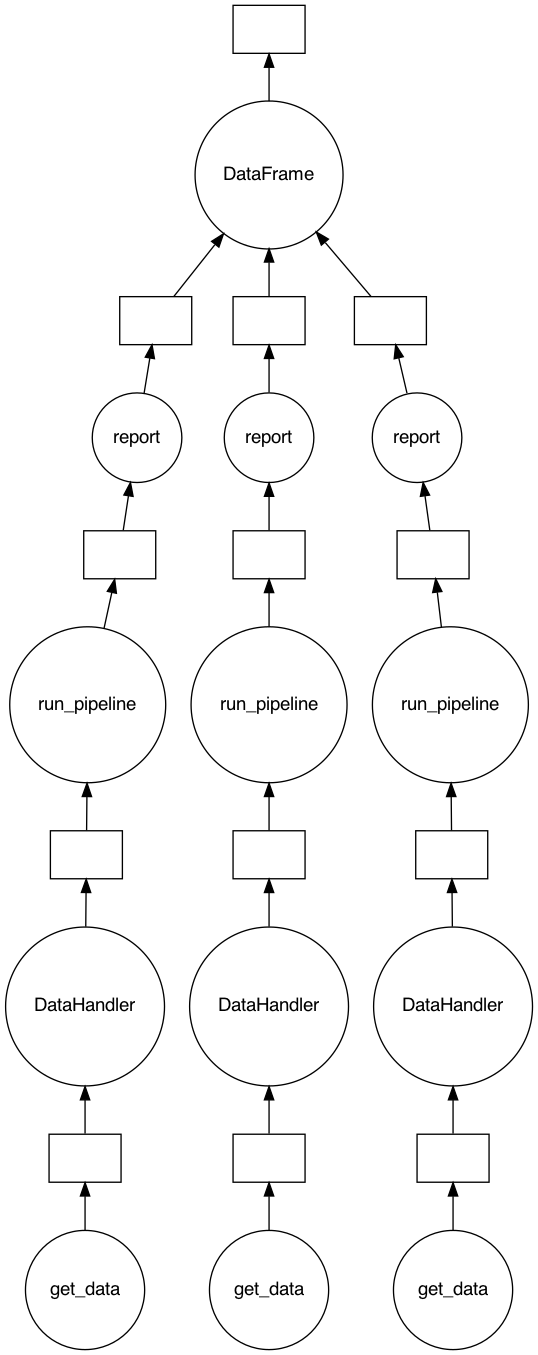

In [10]:
# Define the pipeline run for as single dataset
def run_pipeline(datahandler, solver, solver_convex, verbose=False):
    # Need to call this separately to have it run correctly in task graph 
    # since it doesn't return anything
    datahandler.run_pipeline(solver=solver, solver_convex=solver_convex, verbose=verbose)
    return datahandler


# Call above functions in a for loop over the keys
# and collect results in a DataFrame
reports = []

for key in KEYS:
    
    df = delayed(data_plug.get_data)(key)
    dh = delayed(DataHandler)(df)
    dh_run = delayed(run_pipeline)(dh, solver="OSQP", solver_convex="OSQP", verbose=True)
    report = dh_run.report
    report = delayed(report)(return_values=True, verbose=False)
    reports.append(report)

df_reports = delayed(pd.DataFrame)(reports)

# Visualizing the graph
df_reports.visualize()

# Get User-defined Client

In [11]:
client = Client(memory_limit='32GB') 
client.dashboard_link

'http://127.0.0.1:8787/status'

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62205,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:62232,Total threads: 4
Dashboard: http://127.0.0.1:62236/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:62208,


# Compute pipelines on client

In [13]:
summary_table = client.compute(df_reports)

In [16]:
summary_table

<Future: finished, type: pandas.core.frame.DataFrame, key: DataFrame-90a9cb1e-3e5b-4237-bd6d-e5fd7cb9e655>

# Resulting pipeline reports

In [17]:
summary_table.result()

,length,capacity,sampling,quality score,clearness score,inverter clipping,clipped fraction,capacity change,data quality warning,time shift correction,time zone correction
0,5.473973,2.9908,5,0.965465,0.518018,False,0.000000,True,True,False,0
1,5.473973,6.6387,5,0.818819,0.441441,True,0.131632,True,True,False,0
2,5.473973,5.7549,5,0.969469,0.480480,True,0.060060,True,True,False,0
